# Funções e exemplos de parametros. 

- Função configure_sentinel_hub():
    - Usar suas credenciais Copernicus para criar uma config (configure_sentinel_hub).
    - A config é necessaria para autenticação do usuario a API.


- Função plot_image_bbox():
    - Plotar imagens para pré vizualização com uma Bbox (bounding box).


- Função plot_image_geometry_multipolygon():
    - Plotar imagens para pré vizualização com um Geojson, Json etc cortando a imagem (Clip).
    - tem que definir a variavel <size=> com o tamanho da imagem, caso tenha necessidade.
    

- Funcão plot_image_geometry_multipolygon_resolution():
    - Esta função esta com os tamanho dos pixels definidos passando o valor do parametro (resolution).





In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import (
    SHConfig, SentinelHubCatalog, Geometry, CRS, BBox, DataCollection, DownloadRequest, MimeType,
    MosaickingOrder, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions
)
from utils import plot_image

/home/matheus/app/copernicus-sentinelhub/venv-copernicus/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def configure_sentinel_hub(client_id, client_secret, token_url, base_url, save_config_path):
    """
    Configura as credenciais e o endpoint do Sentinel Hub.

    Args:
        client_id (str): Client ID para autenticação.
        client_secret (str): Client Secret para autenticação.
        token_url (str): URL para obter o token de autenticação.
        base_url (str): Base URL do serviço Sentinel Hub.
        save_config_path (str): Caminho para salvar a configuração.
    
    Returns:
        SHConfig: Objeto de configuração do Sentinel Hub.
    """
    config = SHConfig()
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret
    config.sh_token_url = token_url
    config.sh_base_url = base_url
    config.save(save_config_path)
    return config

In [4]:
def plot_image_bbox(aoi_coords_wgs84, resolution, start_date, end_date, evalscript_true_color, config_name):
    """
    Plota uma imagem em cores reais para uma área de interesse definida por um BBox.

    Args:
        aoi_coords_wgs84 (list): Coordenadas da área de interesse [xmin, ymin, xmax, ymax].
        resolution (int): Resolução da imagem em metros.
        start_date (str): Data de início no formato 'YYYY-MM-DD'.
        end_date (str): Data de término no formato 'YYYY-MM-DD'.
        evalscript_true_color (str): Evalscript para imagem em cores reais.
        config_name (str): Nome da configuração salva.
    """

    # Utilize o mesmo nome que salvou no (save_config_path)
    config = SHConfig(config_name)
    
    aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
    aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)
    print(f'Image shape at {resolution} m resolution: {aoi_size} pixels')

    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(start_date, end_date),
                mosaicking_order=MosaickingOrder.LEAST_CC
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=aoi_bbox,
        size=aoi_size,
        config=config,
    )
    true_color_imgs = request_true_color.get_data()
    image = true_color_imgs[0]
    print(f"Image type: {image.dtype}")

    # Plot the image
    plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [5]:
def plot_image_geometry_multipolygon(start_date, end_date, geometry_val, evalscript_type, config_name):
    """
    Plota uma imagem baseada em geometria multipolygon definindo um tamanho especifico para o tamanho da imagem.

    Args:
        start_date (str): Data de início no formato 'YYYY-MM-DD'.
        end_date (str): Data de término no formato 'YYYY-MM-DD'.
        geometry_val (dict): Geometria no formato GeoJSON.
        evalscript_type (str): Evalscript para o tipo de índice.
        config_name (str): Nome da configuração salva.
    """
    config = SHConfig(config_name)
    geometry = Geometry(geometry=geometry_val, crs=CRS.WGS84)

    request_true_color = SentinelHubRequest(
        evalscript=evalscript_type,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(start_date, end_date),
                mosaicking_order=MosaickingOrder.LEAST_CC
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry=geometry,
        size=[2500, 1500],
        config=config
    )
    geo_color_imgs = request_true_color.get_data()
    image = geo_color_imgs[0]
    print(f"Image type: {image.dtype}")

    # Plot the image
    plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [6]:

def plot_image_geometry_multipolygon_resolution(start_date, end_date, geometry_val, evalscript_type, config_name, resolution):
    """
    Plota uma imagem baseada em geometria multipolygon sem ter definindo um tamanho especifico para o tamanho da imagem.

    Args:
        start_date (str): Data de início no formato 'YYYY-MM-DD'.
        end_date (str): Data de término no formato 'YYYY-MM-DD'.
        geometry_val (dict): Geometria no formato GeoJSON.
        evalscript_type (str): Evalscript para o tipo de índice.
        config_name (str): Nome da configuração salva.
        resolution (int): Resolução desejada em metros.
    """
    config = SHConfig(config_name)
    geometry = Geometry(geometry=geometry_val, crs=CRS.WGS84)
    
    # Calcular o tamanho baseado na geometria e na resolução
    bbox = geometry.bbox
    image_size = bbox_to_dimensions(bbox, resolution=resolution)
    
    request_true_color = SentinelHubRequest(
        evalscript=evalscript_type,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(start_date, end_date),
                mosaicking_order=MosaickingOrder.LEAST_CC
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry=geometry,
        size=image_size,
        config=config
    )
    geo_color_imgs = request_true_color.get_data()
    image = geo_color_imgs[0]
    print(f"Image type: {image.dtype}")

    # Plot the image
    plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [7]:
def donwload_bands(start_date, end_date, geometry_val, evalscript_type, config_name, resolution=10):

  config = SHConfig(config_name)
  geometry = Geometry(geometry=geometry_val, crs=CRS.WGS84)
  
  # Calcular o tamanho baseado na geometria e na resolução
  bbox = geometry.bbox
  image_size = bbox_to_dimensions(bbox, resolution=resolution)
  
  request_all_bands = SentinelHubRequest(
    data_folder="diretorio_tiff",
      evalscript=evalscript_type,
      input_data=[
          SentinelHubRequest.input_data(
              data_collection=DataCollection.SENTINEL2_L2A.define_from(
                  name="s2", service_url="https://sh.dataspace.copernicus.eu"
              ),
              time_interval=(start_date, end_date),
              mosaicking_order=MosaickingOrder.LEAST_CC
          )
      ],
      responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
      geometry=geometry,
      size=image_size,
      config=config
  )

  all_bands_img = request_all_bands.get_data(save_data=True)

  print(
    "The output directory has been created and a tiff file with all bands was saved into the following structure:\n"
)

  for folder, _, filenames in os.walk(request_all_bands.data_folder):
      for filename in filenames:
          print(os.path.join(folder, filename)) 

Image shape at 5 m resolution: (1058, 751) pixels
Image type: uint8


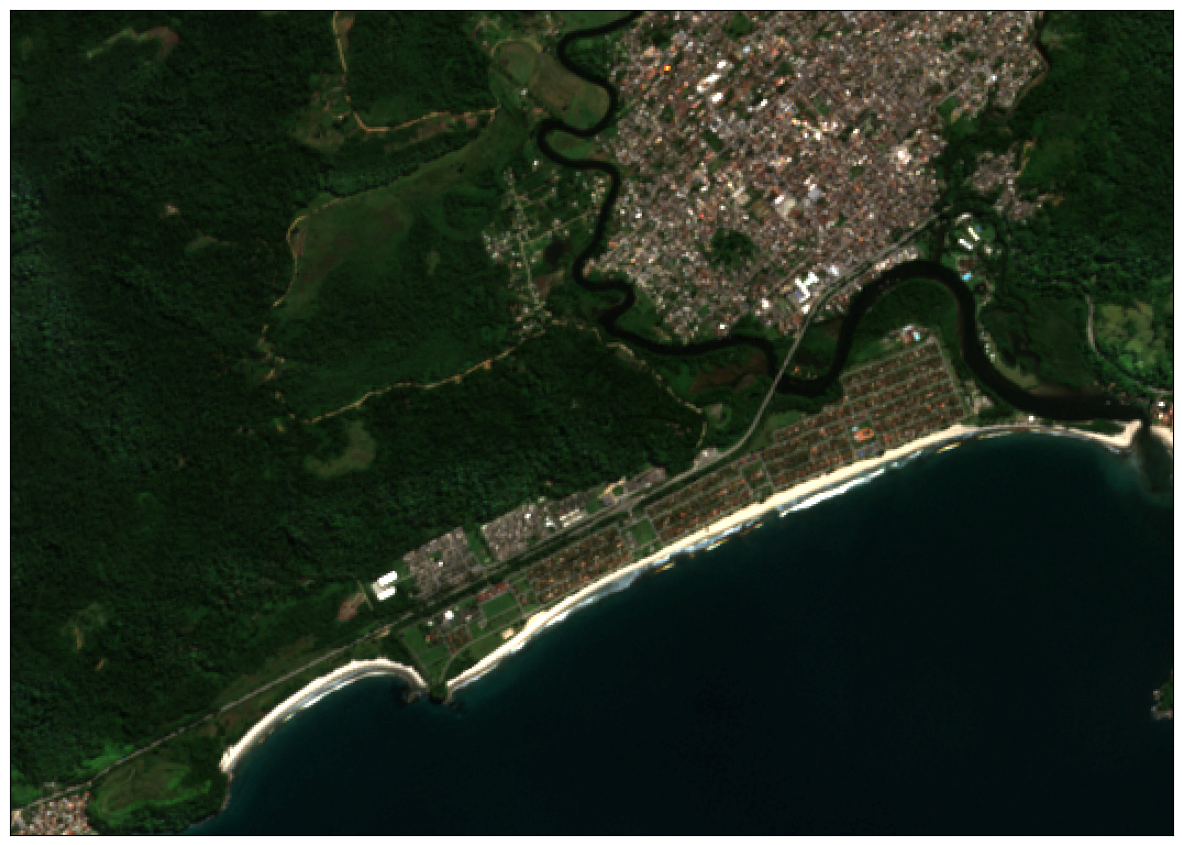

In [8]:
 # Definir parâmetros
aoi_coords_wgs84 = [-44.571276, -23.043405, -44.519777, -23.009359]
config_name = "cdse"
resolution = 5
start_date = '2024-04-21'
end_date = '2024-05-21'
evalscript_true_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{ bands: ["B02", "B03", "B04"] }],
            output: { bands: 3 }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

plot_image_bbox(aoi_coords_wgs84, resolution, start_date, end_date, evalscript_true_color, config_name)


Image type: uint8


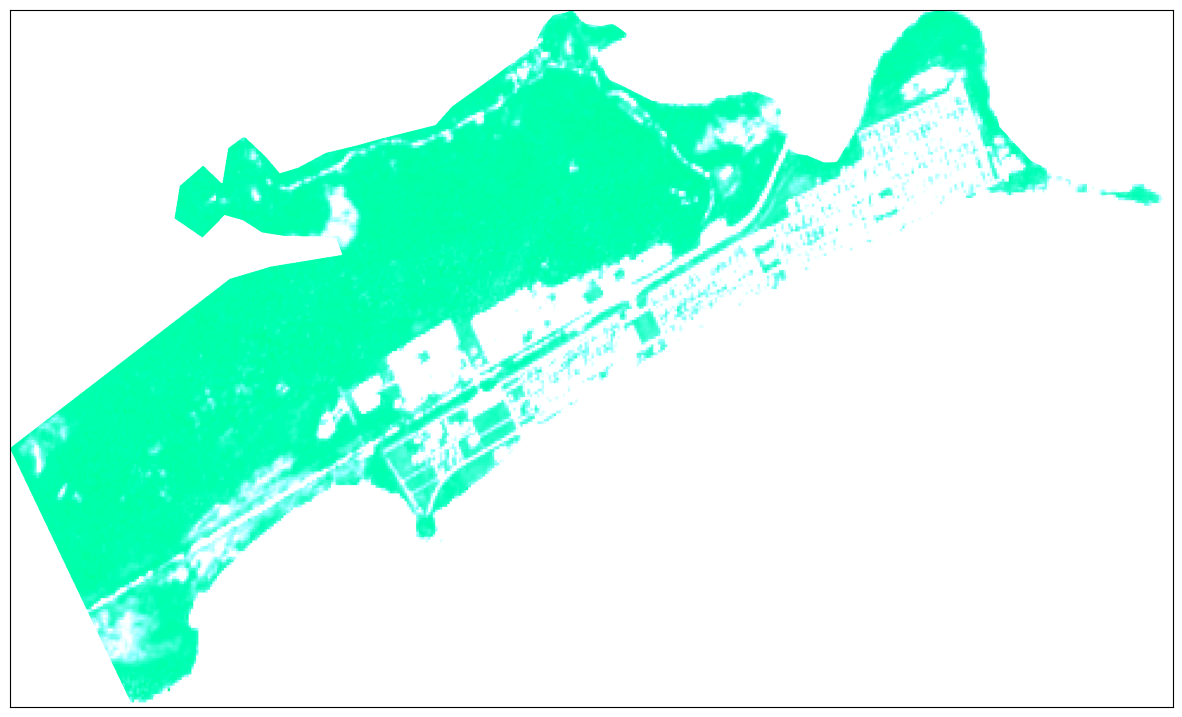

In [9]:
config_name = "cdse"
geometry_val = { "type": "Polygon", "coordinates": [ [ [ -44.558659307241207, -23.028935537391185 ], [ -44.555712454246965, -23.028546313079456 ], [ -44.555958025329829, -23.027993863739578 ], [ -44.557158595068216, -23.027931085262221 ], [ -44.55811359372376, -23.027918529563244 ], [ -44.559014021027558, -23.027805528219822 ], [ -44.559791662789927, -23.027403744898251 ], [ -44.560555661714368, -23.027227964318488 ], [ -44.561469731856093, -23.027968752352134 ], [ -44.56261573024274, -23.027340966146085 ], [ -44.56239744483576, -23.026273722885957 ], [ -44.561442446180209, -23.025608261047104 ], [ -44.560651161579891, -23.026210943607516 ], [ -44.560555661714361, -23.025746376038519 ], [ -44.560405590497055, -23.0250306877318 ], [ -44.55976437711405, -23.024641452145403 ], [ -44.559368734813908, -23.024930239946116 ], [ -44.55883666413439, -23.025344586579706 ], [ -44.558290950616922, -23.025859379108073 ], [ -44.557526951692495, -23.025671040606216 ], [ -44.556380953305855, -23.025181359270011 ], [ -44.555139455053649, -23.024942795923415 ], [ -44.554007099504922, -23.024691676155157 ], [ -44.551878816786882, -23.024264771475657 ], [ -44.551196674890051, -23.023649524118483 ], [ -44.549504962985957, -23.022682701170538 ], [ -44.548877392440893, -23.022306015028381 ], [ -44.548045179326785, -23.021828877737612 ], [ -44.547772322568051, -23.021527526999833 ], [ -44.547444894457591, -23.021000161588134 ], [ -44.547035609319494, -23.020636027123974 ], [ -44.546558109991707, -23.020560688836198 ], [ -44.546203396205378, -23.020460237720357 ], [ -44.545957825122521, -23.02077414720889 ], [ -44.54571225403965, -23.020924823503819 ], [ -44.545098326332543, -23.021000161588141 ], [ -44.544620827004749, -23.020924823503826 ], [ -44.54433432740808, -23.021062943292929 ], [ -44.543993256459693, -23.021276400870544 ], [ -44.544197899028738, -23.021590308459075 ], [ -44.544907326601425, -23.02195444034626 ], [ -44.54511196917047, -23.022218121443792 ], [ -44.54475725538412, -23.022758038272695 ], [ -44.544116042001107, -23.023009161642509 ], [ -44.542983686452402, -23.023461182529505 ], [ -44.541851330903704, -23.023574187514463 ], [ -44.540800832382608, -23.023461182529505 ], [ -44.538904477909441, -23.023122167006335 ], [ -44.53790855074012, -23.023423514180138 ], [ -44.537499265602023, -23.024114098913085 ], [ -44.537662979657249, -23.024465667963813 ], [ -44.537294623032977, -23.024490780003788 ], [ -44.53732190870884, -23.025068355632143 ], [ -44.537049051950113, -23.025206471176677 ], [ -44.536598838298218, -23.025269250922854 ], [ -44.53593033923935, -23.025495257767087 ], [ -44.535384625721889, -23.025482701841227 ], [ -44.53487984071824, -23.024792124118598 ], [ -44.53436141287667, -23.023875533677984 ], [ -44.534020341928262, -23.022343683689961 ], [ -44.533338200031444, -23.021602864747408 ], [ -44.532683343810511, -23.021201062940559 ], [ -44.531919344886063, -23.020560688836198 ], [ -44.53107348893402, -23.02046023772035 ], [ -44.530486846902761, -23.020435124929708 ], [ -44.529545491085152, -23.020786703573236 ], [ -44.529067991757394, -23.021703315012036 ], [ -44.528917920540096, -23.023561631409713 ], [ -44.528699635133115, -23.024327551660374 ], [ -44.527403565529163, -23.025445034056666 ], [ -44.525752782138859, -23.026097940832681 ], [ -44.524497641048733, -23.026185831887961 ], [ -44.523297071310338, -23.026072829092072 ], [ -44.522396644006527, -23.02628627873812 ], [ -44.521564430892425, -23.026587618839539 ], [ -44.521578073730346, -23.02719029702158 ], [ -44.522123787247821, -23.027441412135516 ], [ -44.52273771495495, -23.027340966146088 ], [ -44.524756854969517, -23.026838735076154 ], [ -44.526612280928859, -23.026662953759633 ], [ -44.528044778912154, -23.026826179275442 ], [ -44.530022990412931, -23.027290743123274 ], [ -44.532260415834472, -23.027993863739571 ], [ -44.534456912742236, -23.02880998128439 ], [ -44.535480125587455, -23.029274538295319 ], [ -44.536639766812023, -23.029676316040597 ], [ -44.537171837491563, -23.029965093055289 ], [ -44.539532048454539, -23.030894197513565 ], [ -44.543611256997465, -23.03257661361112 ], [ -44.545016469304926, -23.033154154593223 ], [ -44.546680895533136, -23.034033016556123 ], [ -44.548004250812966, -23.03498720305469 ], [ -44.54920482055136, -23.036079487199554 ], [ -44.551305817593551, -23.037385194558649 ], [ -44.551428603134987, -23.037812057681563 ], [ -44.551851531110998, -23.038188700490451 ], [ -44.552383601790524, -23.038251474189572 ], [ -44.552929315307971, -23.037824612458824 ], [ -44.553488671663374, -23.037209426997322 ], [ -44.553829742611761, -23.036644458282911 ], [ -44.554689241401761, -23.036456134851672 ], [ -44.556094453709193, -23.036619348507269 ], [ -44.557526951692495, -23.037196872162735 ], [ -44.560009948196921, -23.038904318926562 ], [ -44.561442446180209, -23.04038576255677 ], [ -44.561155946583561, -23.040661962109812 ], [ -44.561142303745612, -23.041226913977223 ], [ -44.561442446180209, -23.042068060145443 ], [ -44.561933588345923, -23.042432136708968 ], [ -44.562874944163546, -23.043059852611009 ], [ -44.56432108498479, -23.043461589253155 ], [ -44.569382577859145, -23.034924427834795 ], [ -44.560337376307373, -23.029337316146982 ], [ -44.558659307241207, -23.028935537391185 ] ] ] }

start_date = '2023-06-12'
end_date = '2024-06-21'
evalscript_ndvi = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08", "dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  let ndviP = index(sample.B08, sample.B04) * 100;

  return [...visualizer.process(ndviP), sample.dataMask]
  
}

const ramp = [[0.0, '0xffffe5'],
 [10.0, '0xf9fdc2'],
 [20.0, '0xe5f5ac'],
 [30.0, '0xc7e89b'],
 [40.0, '0xa2d88a'],
 [50.0, '0x78c679'],
 [60.0, '0x4cb063'],
 [70.0, '0x2f944d'],
 [80.0, '0x15793e'],
 [90.0, '0x006134'],
 [100.0, '0x004529']];

 const visualizer = new ColorRampVisualizer(ramp);
"""

plot_image_geometry_multipolygon(start_date, end_date, geometry_val, evalscript_ndvi, config_name)

Image type: uint8


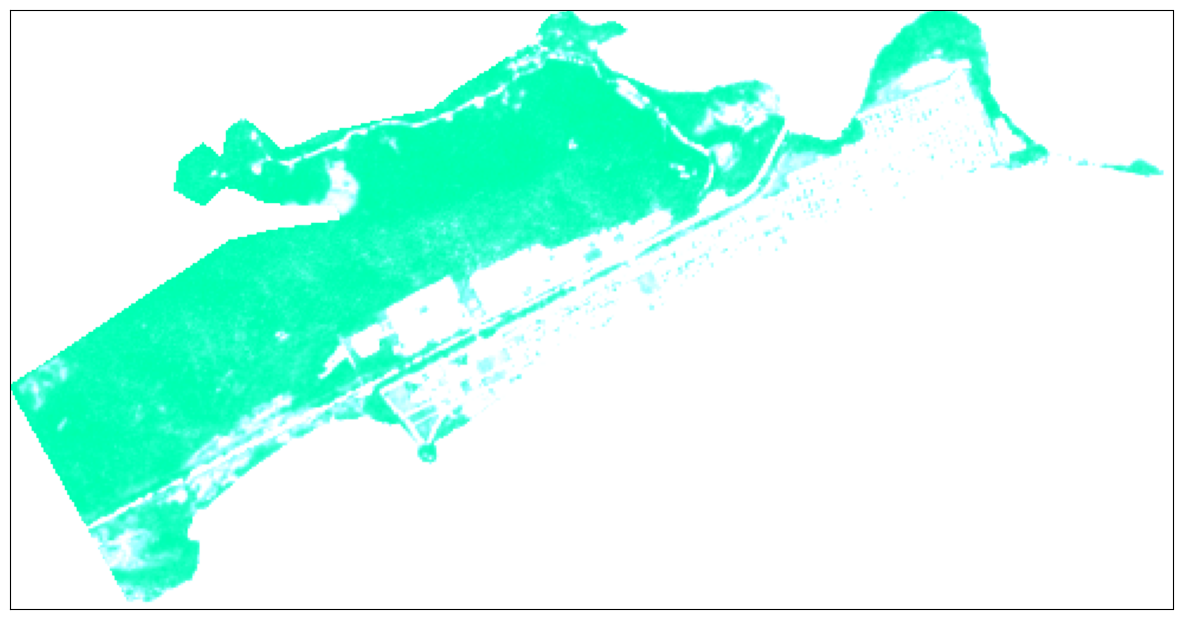

In [10]:
config_name = "cdse"
geometry_val = { "type": "Polygon", "coordinates": [ [ [ -44.558659307241207, -23.028935537391185 ], [ -44.555712454246965, -23.028546313079456 ], [ -44.555958025329829, -23.027993863739578 ], [ -44.557158595068216, -23.027931085262221 ], [ -44.55811359372376, -23.027918529563244 ], [ -44.559014021027558, -23.027805528219822 ], [ -44.559791662789927, -23.027403744898251 ], [ -44.560555661714368, -23.027227964318488 ], [ -44.561469731856093, -23.027968752352134 ], [ -44.56261573024274, -23.027340966146085 ], [ -44.56239744483576, -23.026273722885957 ], [ -44.561442446180209, -23.025608261047104 ], [ -44.560651161579891, -23.026210943607516 ], [ -44.560555661714361, -23.025746376038519 ], [ -44.560405590497055, -23.0250306877318 ], [ -44.55976437711405, -23.024641452145403 ], [ -44.559368734813908, -23.024930239946116 ], [ -44.55883666413439, -23.025344586579706 ], [ -44.558290950616922, -23.025859379108073 ], [ -44.557526951692495, -23.025671040606216 ], [ -44.556380953305855, -23.025181359270011 ], [ -44.555139455053649, -23.024942795923415 ], [ -44.554007099504922, -23.024691676155157 ], [ -44.551878816786882, -23.024264771475657 ], [ -44.551196674890051, -23.023649524118483 ], [ -44.549504962985957, -23.022682701170538 ], [ -44.548877392440893, -23.022306015028381 ], [ -44.548045179326785, -23.021828877737612 ], [ -44.547772322568051, -23.021527526999833 ], [ -44.547444894457591, -23.021000161588134 ], [ -44.547035609319494, -23.020636027123974 ], [ -44.546558109991707, -23.020560688836198 ], [ -44.546203396205378, -23.020460237720357 ], [ -44.545957825122521, -23.02077414720889 ], [ -44.54571225403965, -23.020924823503819 ], [ -44.545098326332543, -23.021000161588141 ], [ -44.544620827004749, -23.020924823503826 ], [ -44.54433432740808, -23.021062943292929 ], [ -44.543993256459693, -23.021276400870544 ], [ -44.544197899028738, -23.021590308459075 ], [ -44.544907326601425, -23.02195444034626 ], [ -44.54511196917047, -23.022218121443792 ], [ -44.54475725538412, -23.022758038272695 ], [ -44.544116042001107, -23.023009161642509 ], [ -44.542983686452402, -23.023461182529505 ], [ -44.541851330903704, -23.023574187514463 ], [ -44.540800832382608, -23.023461182529505 ], [ -44.538904477909441, -23.023122167006335 ], [ -44.53790855074012, -23.023423514180138 ], [ -44.537499265602023, -23.024114098913085 ], [ -44.537662979657249, -23.024465667963813 ], [ -44.537294623032977, -23.024490780003788 ], [ -44.53732190870884, -23.025068355632143 ], [ -44.537049051950113, -23.025206471176677 ], [ -44.536598838298218, -23.025269250922854 ], [ -44.53593033923935, -23.025495257767087 ], [ -44.535384625721889, -23.025482701841227 ], [ -44.53487984071824, -23.024792124118598 ], [ -44.53436141287667, -23.023875533677984 ], [ -44.534020341928262, -23.022343683689961 ], [ -44.533338200031444, -23.021602864747408 ], [ -44.532683343810511, -23.021201062940559 ], [ -44.531919344886063, -23.020560688836198 ], [ -44.53107348893402, -23.02046023772035 ], [ -44.530486846902761, -23.020435124929708 ], [ -44.529545491085152, -23.020786703573236 ], [ -44.529067991757394, -23.021703315012036 ], [ -44.528917920540096, -23.023561631409713 ], [ -44.528699635133115, -23.024327551660374 ], [ -44.527403565529163, -23.025445034056666 ], [ -44.525752782138859, -23.026097940832681 ], [ -44.524497641048733, -23.026185831887961 ], [ -44.523297071310338, -23.026072829092072 ], [ -44.522396644006527, -23.02628627873812 ], [ -44.521564430892425, -23.026587618839539 ], [ -44.521578073730346, -23.02719029702158 ], [ -44.522123787247821, -23.027441412135516 ], [ -44.52273771495495, -23.027340966146088 ], [ -44.524756854969517, -23.026838735076154 ], [ -44.526612280928859, -23.026662953759633 ], [ -44.528044778912154, -23.026826179275442 ], [ -44.530022990412931, -23.027290743123274 ], [ -44.532260415834472, -23.027993863739571 ], [ -44.534456912742236, -23.02880998128439 ], [ -44.535480125587455, -23.029274538295319 ], [ -44.536639766812023, -23.029676316040597 ], [ -44.537171837491563, -23.029965093055289 ], [ -44.539532048454539, -23.030894197513565 ], [ -44.543611256997465, -23.03257661361112 ], [ -44.545016469304926, -23.033154154593223 ], [ -44.546680895533136, -23.034033016556123 ], [ -44.548004250812966, -23.03498720305469 ], [ -44.54920482055136, -23.036079487199554 ], [ -44.551305817593551, -23.037385194558649 ], [ -44.551428603134987, -23.037812057681563 ], [ -44.551851531110998, -23.038188700490451 ], [ -44.552383601790524, -23.038251474189572 ], [ -44.552929315307971, -23.037824612458824 ], [ -44.553488671663374, -23.037209426997322 ], [ -44.553829742611761, -23.036644458282911 ], [ -44.554689241401761, -23.036456134851672 ], [ -44.556094453709193, -23.036619348507269 ], [ -44.557526951692495, -23.037196872162735 ], [ -44.560009948196921, -23.038904318926562 ], [ -44.561442446180209, -23.04038576255677 ], [ -44.561155946583561, -23.040661962109812 ], [ -44.561142303745612, -23.041226913977223 ], [ -44.561442446180209, -23.042068060145443 ], [ -44.561933588345923, -23.042432136708968 ], [ -44.562874944163546, -23.043059852611009 ], [ -44.56432108498479, -23.043461589253155 ], [ -44.569382577859145, -23.034924427834795 ], [ -44.560337376307373, -23.029337316146982 ], [ -44.558659307241207, -23.028935537391185 ] ] ] }
resolution=10
start_date = '2023-06-12'
end_date = '2023-06-21'
evalscript_type = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08", "dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  let ndviP = index(sample.B08, sample.B04) * 100;

  return [...visualizer.process(ndviP), sample.dataMask]
  
}

const ramp = [[0.0, '0xffffe5'],
 [10.0, '0xf9fdc2'],
 [20.0, '0xe5f5ac'],
 [30.0, '0xc7e89b'],
 [40.0, '0xa2d88a'],
 [50.0, '0x78c679'],
 [60.0, '0x4cb063'],
 [70.0, '0x2f944d'],
 [80.0, '0x15793e'],
 [90.0, '0x006134'],
 [100.0, '0x004529']];

 const visualizer = new ColorRampVisualizer(ramp);
"""





plot_image_geometry_multipolygon_resolution(start_date, end_date, geometry_val, evalscript_type, config_name, resolution)

In [11]:
config_name = "cdse"
geometry_val = { "type": "Polygon", "coordinates": [ [ [ -44.558659307241207, -23.028935537391185 ], [ -44.555712454246965, -23.028546313079456 ], [ -44.555958025329829, -23.027993863739578 ], [ -44.557158595068216, -23.027931085262221 ], [ -44.55811359372376, -23.027918529563244 ], [ -44.559014021027558, -23.027805528219822 ], [ -44.559791662789927, -23.027403744898251 ], [ -44.560555661714368, -23.027227964318488 ], [ -44.561469731856093, -23.027968752352134 ], [ -44.56261573024274, -23.027340966146085 ], [ -44.56239744483576, -23.026273722885957 ], [ -44.561442446180209, -23.025608261047104 ], [ -44.560651161579891, -23.026210943607516 ], [ -44.560555661714361, -23.025746376038519 ], [ -44.560405590497055, -23.0250306877318 ], [ -44.55976437711405, -23.024641452145403 ], [ -44.559368734813908, -23.024930239946116 ], [ -44.55883666413439, -23.025344586579706 ], [ -44.558290950616922, -23.025859379108073 ], [ -44.557526951692495, -23.025671040606216 ], [ -44.556380953305855, -23.025181359270011 ], [ -44.555139455053649, -23.024942795923415 ], [ -44.554007099504922, -23.024691676155157 ], [ -44.551878816786882, -23.024264771475657 ], [ -44.551196674890051, -23.023649524118483 ], [ -44.549504962985957, -23.022682701170538 ], [ -44.548877392440893, -23.022306015028381 ], [ -44.548045179326785, -23.021828877737612 ], [ -44.547772322568051, -23.021527526999833 ], [ -44.547444894457591, -23.021000161588134 ], [ -44.547035609319494, -23.020636027123974 ], [ -44.546558109991707, -23.020560688836198 ], [ -44.546203396205378, -23.020460237720357 ], [ -44.545957825122521, -23.02077414720889 ], [ -44.54571225403965, -23.020924823503819 ], [ -44.545098326332543, -23.021000161588141 ], [ -44.544620827004749, -23.020924823503826 ], [ -44.54433432740808, -23.021062943292929 ], [ -44.543993256459693, -23.021276400870544 ], [ -44.544197899028738, -23.021590308459075 ], [ -44.544907326601425, -23.02195444034626 ], [ -44.54511196917047, -23.022218121443792 ], [ -44.54475725538412, -23.022758038272695 ], [ -44.544116042001107, -23.023009161642509 ], [ -44.542983686452402, -23.023461182529505 ], [ -44.541851330903704, -23.023574187514463 ], [ -44.540800832382608, -23.023461182529505 ], [ -44.538904477909441, -23.023122167006335 ], [ -44.53790855074012, -23.023423514180138 ], [ -44.537499265602023, -23.024114098913085 ], [ -44.537662979657249, -23.024465667963813 ], [ -44.537294623032977, -23.024490780003788 ], [ -44.53732190870884, -23.025068355632143 ], [ -44.537049051950113, -23.025206471176677 ], [ -44.536598838298218, -23.025269250922854 ], [ -44.53593033923935, -23.025495257767087 ], [ -44.535384625721889, -23.025482701841227 ], [ -44.53487984071824, -23.024792124118598 ], [ -44.53436141287667, -23.023875533677984 ], [ -44.534020341928262, -23.022343683689961 ], [ -44.533338200031444, -23.021602864747408 ], [ -44.532683343810511, -23.021201062940559 ], [ -44.531919344886063, -23.020560688836198 ], [ -44.53107348893402, -23.02046023772035 ], [ -44.530486846902761, -23.020435124929708 ], [ -44.529545491085152, -23.020786703573236 ], [ -44.529067991757394, -23.021703315012036 ], [ -44.528917920540096, -23.023561631409713 ], [ -44.528699635133115, -23.024327551660374 ], [ -44.527403565529163, -23.025445034056666 ], [ -44.525752782138859, -23.026097940832681 ], [ -44.524497641048733, -23.026185831887961 ], [ -44.523297071310338, -23.026072829092072 ], [ -44.522396644006527, -23.02628627873812 ], [ -44.521564430892425, -23.026587618839539 ], [ -44.521578073730346, -23.02719029702158 ], [ -44.522123787247821, -23.027441412135516 ], [ -44.52273771495495, -23.027340966146088 ], [ -44.524756854969517, -23.026838735076154 ], [ -44.526612280928859, -23.026662953759633 ], [ -44.528044778912154, -23.026826179275442 ], [ -44.530022990412931, -23.027290743123274 ], [ -44.532260415834472, -23.027993863739571 ], [ -44.534456912742236, -23.02880998128439 ], [ -44.535480125587455, -23.029274538295319 ], [ -44.536639766812023, -23.029676316040597 ], [ -44.537171837491563, -23.029965093055289 ], [ -44.539532048454539, -23.030894197513565 ], [ -44.543611256997465, -23.03257661361112 ], [ -44.545016469304926, -23.033154154593223 ], [ -44.546680895533136, -23.034033016556123 ], [ -44.548004250812966, -23.03498720305469 ], [ -44.54920482055136, -23.036079487199554 ], [ -44.551305817593551, -23.037385194558649 ], [ -44.551428603134987, -23.037812057681563 ], [ -44.551851531110998, -23.038188700490451 ], [ -44.552383601790524, -23.038251474189572 ], [ -44.552929315307971, -23.037824612458824 ], [ -44.553488671663374, -23.037209426997322 ], [ -44.553829742611761, -23.036644458282911 ], [ -44.554689241401761, -23.036456134851672 ], [ -44.556094453709193, -23.036619348507269 ], [ -44.557526951692495, -23.037196872162735 ], [ -44.560009948196921, -23.038904318926562 ], [ -44.561442446180209, -23.04038576255677 ], [ -44.561155946583561, -23.040661962109812 ], [ -44.561142303745612, -23.041226913977223 ], [ -44.561442446180209, -23.042068060145443 ], [ -44.561933588345923, -23.042432136708968 ], [ -44.562874944163546, -23.043059852611009 ], [ -44.56432108498479, -23.043461589253155 ], [ -44.569382577859145, -23.034924427834795 ], [ -44.560337376307373, -23.029337316146982 ], [ -44.558659307241207, -23.028935537391185 ] ] ] }

start_date = '2023-06-12'
end_date = '2023-06-21'
evalscript_type = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08", "dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  let ndviP = index(sample.B08, sample.B04) * 100;

  return [...visualizer.process(ndviP), sample.dataMask]
  
}

const ramp = [[0.0, '0xffffe5'],
 [10.0, '0xf9fdc2'],
 [20.0, '0xe5f5ac'],
 [30.0, '0xc7e89b'],
 [40.0, '0xa2d88a'],
 [50.0, '0x78c679'],
 [60.0, '0x4cb063'],
 [70.0, '0x2f944d'],
 [80.0, '0x15793e'],
 [90.0, '0x006134'],
 [100.0, '0x004529']];

 const visualizer = new ColorRampVisualizer(ramp);
"""


donwload_bands(start_date, end_date, geometry_val, evalscript_type, config_name, resolution=10)

The output directory has been created and a tiff file with all bands was saved into the following structure:

diretorio_tiff/c9cff354e66095079cdfe92e6acd14c8/response.tiff
diretorio_tiff/c9cff354e66095079cdfe92e6acd14c8/request.json


In [12]:
import base64
from io import BytesIO
from PIL import Image
from sentinelhub import SHConfig, Geometry, CRS, SentinelHubRequest, DataCollection, bbox_to_dimensions, MimeType, MosaickingOrder

def return_image_geometry_multipolygon_resolution(start_date, end_date, geometry_val, evalscript_type, config_name, resolution):
    """
    Gera uma imagem baseada em geometria multipolygon sem ter definindo um tamanho especifico para o tamanho da imagem e retorna a imagem em base64.

    Args:
        start_date (str): Data de início no formato 'YYYY-MM-DD'.
        end_date (str): Data de término no formato 'YYYY-MM-DD'.
        geometry_val (dict): Geometria no formato GeoJSON.
        evalscript_type (str): Evalscript para o tipo de índice.
        config_name (str): Nome da configuração salva.
        resolution (int): Resolução desejada em metros.
    
    Returns:
        str: Imagem em base64.
    """
    config = SHConfig(config_name)
    geometry = Geometry(geometry=geometry_val, crs=CRS.WGS84)
    
    # Calcular o tamanho baseado na geometria e na resolução
    bbox = geometry.bbox
    image_size = bbox_to_dimensions(bbox, resolution=resolution)
    
    request_true_color = SentinelHubRequest(
        evalscript=evalscript_type,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(start_date, end_date),
                mosaicking_order=MosaickingOrder.LEAST_CC
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry=geometry,
        size=image_size,
        config=config
    )
    geo_color_imgs = request_true_color.get_data()
    image = geo_color_imgs[0]
    print(f"Image type: {image.dtype}")

    # Convert the image to base64
    pil_image = Image.fromarray(image)
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    
    return img_str


In [13]:
config_name = "cdse"
geometry_val = { "type": "Polygon", "coordinates": [ [ [ -44.558659307241207, -23.028935537391185 ], [ -44.555712454246965, -23.028546313079456 ], [ -44.555958025329829, -23.027993863739578 ], [ -44.557158595068216, -23.027931085262221 ], [ -44.55811359372376, -23.027918529563244 ], [ -44.559014021027558, -23.027805528219822 ], [ -44.559791662789927, -23.027403744898251 ], [ -44.560555661714368, -23.027227964318488 ], [ -44.561469731856093, -23.027968752352134 ], [ -44.56261573024274, -23.027340966146085 ], [ -44.56239744483576, -23.026273722885957 ], [ -44.561442446180209, -23.025608261047104 ], [ -44.560651161579891, -23.026210943607516 ], [ -44.560555661714361, -23.025746376038519 ], [ -44.560405590497055, -23.0250306877318 ], [ -44.55976437711405, -23.024641452145403 ], [ -44.559368734813908, -23.024930239946116 ], [ -44.55883666413439, -23.025344586579706 ], [ -44.558290950616922, -23.025859379108073 ], [ -44.557526951692495, -23.025671040606216 ], [ -44.556380953305855, -23.025181359270011 ], [ -44.555139455053649, -23.024942795923415 ], [ -44.554007099504922, -23.024691676155157 ], [ -44.551878816786882, -23.024264771475657 ], [ -44.551196674890051, -23.023649524118483 ], [ -44.549504962985957, -23.022682701170538 ], [ -44.548877392440893, -23.022306015028381 ], [ -44.548045179326785, -23.021828877737612 ], [ -44.547772322568051, -23.021527526999833 ], [ -44.547444894457591, -23.021000161588134 ], [ -44.547035609319494, -23.020636027123974 ], [ -44.546558109991707, -23.020560688836198 ], [ -44.546203396205378, -23.020460237720357 ], [ -44.545957825122521, -23.02077414720889 ], [ -44.54571225403965, -23.020924823503819 ], [ -44.545098326332543, -23.021000161588141 ], [ -44.544620827004749, -23.020924823503826 ], [ -44.54433432740808, -23.021062943292929 ], [ -44.543993256459693, -23.021276400870544 ], [ -44.544197899028738, -23.021590308459075 ], [ -44.544907326601425, -23.02195444034626 ], [ -44.54511196917047, -23.022218121443792 ], [ -44.54475725538412, -23.022758038272695 ], [ -44.544116042001107, -23.023009161642509 ], [ -44.542983686452402, -23.023461182529505 ], [ -44.541851330903704, -23.023574187514463 ], [ -44.540800832382608, -23.023461182529505 ], [ -44.538904477909441, -23.023122167006335 ], [ -44.53790855074012, -23.023423514180138 ], [ -44.537499265602023, -23.024114098913085 ], [ -44.537662979657249, -23.024465667963813 ], [ -44.537294623032977, -23.024490780003788 ], [ -44.53732190870884, -23.025068355632143 ], [ -44.537049051950113, -23.025206471176677 ], [ -44.536598838298218, -23.025269250922854 ], [ -44.53593033923935, -23.025495257767087 ], [ -44.535384625721889, -23.025482701841227 ], [ -44.53487984071824, -23.024792124118598 ], [ -44.53436141287667, -23.023875533677984 ], [ -44.534020341928262, -23.022343683689961 ], [ -44.533338200031444, -23.021602864747408 ], [ -44.532683343810511, -23.021201062940559 ], [ -44.531919344886063, -23.020560688836198 ], [ -44.53107348893402, -23.02046023772035 ], [ -44.530486846902761, -23.020435124929708 ], [ -44.529545491085152, -23.020786703573236 ], [ -44.529067991757394, -23.021703315012036 ], [ -44.528917920540096, -23.023561631409713 ], [ -44.528699635133115, -23.024327551660374 ], [ -44.527403565529163, -23.025445034056666 ], [ -44.525752782138859, -23.026097940832681 ], [ -44.524497641048733, -23.026185831887961 ], [ -44.523297071310338, -23.026072829092072 ], [ -44.522396644006527, -23.02628627873812 ], [ -44.521564430892425, -23.026587618839539 ], [ -44.521578073730346, -23.02719029702158 ], [ -44.522123787247821, -23.027441412135516 ], [ -44.52273771495495, -23.027340966146088 ], [ -44.524756854969517, -23.026838735076154 ], [ -44.526612280928859, -23.026662953759633 ], [ -44.528044778912154, -23.026826179275442 ], [ -44.530022990412931, -23.027290743123274 ], [ -44.532260415834472, -23.027993863739571 ], [ -44.534456912742236, -23.02880998128439 ], [ -44.535480125587455, -23.029274538295319 ], [ -44.536639766812023, -23.029676316040597 ], [ -44.537171837491563, -23.029965093055289 ], [ -44.539532048454539, -23.030894197513565 ], [ -44.543611256997465, -23.03257661361112 ], [ -44.545016469304926, -23.033154154593223 ], [ -44.546680895533136, -23.034033016556123 ], [ -44.548004250812966, -23.03498720305469 ], [ -44.54920482055136, -23.036079487199554 ], [ -44.551305817593551, -23.037385194558649 ], [ -44.551428603134987, -23.037812057681563 ], [ -44.551851531110998, -23.038188700490451 ], [ -44.552383601790524, -23.038251474189572 ], [ -44.552929315307971, -23.037824612458824 ], [ -44.553488671663374, -23.037209426997322 ], [ -44.553829742611761, -23.036644458282911 ], [ -44.554689241401761, -23.036456134851672 ], [ -44.556094453709193, -23.036619348507269 ], [ -44.557526951692495, -23.037196872162735 ], [ -44.560009948196921, -23.038904318926562 ], [ -44.561442446180209, -23.04038576255677 ], [ -44.561155946583561, -23.040661962109812 ], [ -44.561142303745612, -23.041226913977223 ], [ -44.561442446180209, -23.042068060145443 ], [ -44.561933588345923, -23.042432136708968 ], [ -44.562874944163546, -23.043059852611009 ], [ -44.56432108498479, -23.043461589253155 ], [ -44.569382577859145, -23.034924427834795 ], [ -44.560337376307373, -23.029337316146982 ], [ -44.558659307241207, -23.028935537391185 ] ] ] }
resolution=10
start_date = '2023-06-12'
end_date = '2023-06-21'
evalscript_type = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08", "dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  let ndviP = index(sample.B08, sample.B04) * 100;

  return [...visualizer.process(ndviP), sample.dataMask]
  
}

const ramp = [[0.0, '0xffffe5'],
 [10.0, '0xf9fdc2'],
 [20.0, '0xe5f5ac'],
 [30.0, '0xc7e89b'],
 [40.0, '0xa2d88a'],
 [50.0, '0x78c679'],
 [60.0, '0x4cb063'],
 [70.0, '0x2f944d'],
 [80.0, '0x15793e'],
 [90.0, '0x006134'],
 [100.0, '0x004529']];

 const visualizer = new ColorRampVisualizer(ramp);
"""





return_image_geometry_multipolygon_resolution(start_date, end_date, geometry_val, evalscript_type, config_name, resolution)

Image type: uint8


'iVBORw0KGgoAAAANSUhEUgAAAesAAAD9CAYAAACcC1+TAAEAAElEQVR4nOz9d7xk21nfCX/XjpXTyalPh9vdN/XNV1lICJBEUkaAPQZjBNjAmDHjNJ7kmdfj1x4zHvsdj9OAMTY2YwNGJBOEsnR1paubY+fuk/OpXLXTWu8fa+1d1bKREQpXV9Tz+fSnu8+p2rVr1671W8/v+T2/Ryi1ySQmMYmv/5j9G9+vKtUc584u8a2nT/HT9/2weLnPaRLfWPGOX/+f1LPP3eTwoE8cSaRUADiORWO6QLHk4XkO33ThHH/xvgc5U7mffrJByblzci9+lUNMwHoSk/j6jNf/y7+krl/bo9UMcF2LKJJYliCfd/gfv/+tXGk2+Yff9Jcmi+Qk/tjxsy/8K3Wp2eK3P/cMa9ebRFFCkijiUIIAIQRCgAIcR2BZ+o/r2RRLLg8+eIY/e/ddvHbhBDO5JcDCtZYn9+RXISZgPYlJfB1F6afepwpFF993KJY8LCHY3GgTR3rxDIMEIWBxucKPf8cb+KsP/MhkYZzElxzD5LL6mSc/zL/88GfZ3+3R70bEsdS/TBQIwNK3lmUJZCxBCBD6/wCOa1EoupQqHnffdYL/7nWv4VWzt+NaUwTJHgXn9sm9+RWMCVhPYhJfJ5H78fcoyxKUqz71ep44lgyGEcEwRgjBsB/T7YQIk10Xyy6vfvVZfvOd/+tkUZzEHzludD6l+nHI+3/hl7hx/ZjhIEYmCpUoDcigwVqRgbOMZQbeQoBSICyBbWkAz+UdGlN57rv3FP/ybe+m6FZ57ugS84UqF4/3+Oald0zu0S8zJmA9iUl8HYT/F96jAJRSeL6N79sMBwlSKoQFKBgOdFZt2QIB2I7F4nKZB+85zWuWFvnp+z4wWRAn8UXjQ+sfVL9x7Rp/8PgLbG206XZCZKIMRmuEVkrT30opLEv/DfpnUir9O6nAAtsSmiq3dF17erbAn3nra/jfXvMTKEJeOP4U7XD